# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

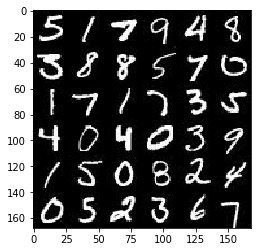

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

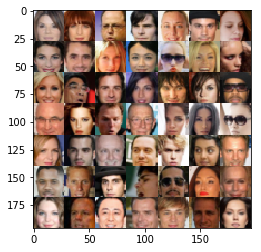

In [3]:
show_n_images = 49

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learn')

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(layer1 * alpha, layer1)
        
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        relu2 = tf.maximum(layer2 * alpha, layer2)
        
        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        relu3 = tf.maximum(layer3 * alpha, layer3)
        
        flattened = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)

        return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    alpha = 0.01
    
    with tf.variable_scope('generator', reuse=reuse):
        n_units = 7*7*256

        layer1 = tf.layers.dense(z, n_units, activation=None)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(layer1 * alpha, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(layer2 * alpha, layer2)
        
        logits = tf.layers.conv2d_transpose(layer2, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    return (discriminator_loss, generator_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """ 
    _, width, height, num_channels = data_shape
    input_real, input_z, learn = model_inputs(width, height, num_channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, num_channels)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learn, beta1)   
    
    steps = 0
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Rescale from (-0.5, 0.5) to (-1, 1). Thanks Udacity forums!
                batch_images *= 2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict = {
                    input_real: batch_images, 
                    input_z: batch_z, 
                    learn: learning_rate
                })
                sess.run(g_opt, feed_dict = {
                    input_real: batch_images,
                    input_z: batch_z, 
                    learn: learning_rate
                })
                    
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                                input_z: batch_z,  
                                                learn: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                learn: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {} ->".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, num_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10 -> Discriminator Loss: 0.1938... Generator Loss: 1.7761
Epoch 1/2... Step 20 -> Discriminator Loss: 0.1383... Generator Loss: 2.3663
Epoch 1/2... Step 30 -> Discriminator Loss: 0.4925... Generator Loss: 1.9205
Epoch 1/2... Step 40 -> Discriminator Loss: 0.4551... Generator Loss: 1.7413
Epoch 1/2... Step 50 -> Discriminator Loss: 1.7046... Generator Loss: 0.2337
Epoch 1/2... Step 60 -> Discriminator Loss: 0.4126... Generator Loss: 1.5468
Epoch 1/2... Step 70 -> Discriminator Loss: 0.2117... Generator Loss: 2.3734
Epoch 1/2... Step 80 -> Discriminator Loss: 0.6023... Generator Loss: 1.8180
Epoch 1/2... Step 90 -> Discriminator Loss: 0.5226... Generator Loss: 1.4690
Epoch 1/2... Step 100 -> Discriminator Loss: 1.0156... Generator Loss: 0.7057


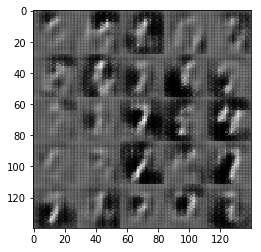

Epoch 1/2... Step 110 -> Discriminator Loss: 1.3603... Generator Loss: 1.7443
Epoch 1/2... Step 120 -> Discriminator Loss: 1.0852... Generator Loss: 0.9163
Epoch 1/2... Step 130 -> Discriminator Loss: 1.1196... Generator Loss: 0.9121
Epoch 1/2... Step 140 -> Discriminator Loss: 1.0644... Generator Loss: 1.0089
Epoch 1/2... Step 150 -> Discriminator Loss: 0.9496... Generator Loss: 0.8813
Epoch 1/2... Step 160 -> Discriminator Loss: 1.2320... Generator Loss: 0.5195
Epoch 1/2... Step 170 -> Discriminator Loss: 1.1571... Generator Loss: 0.9064
Epoch 1/2... Step 180 -> Discriminator Loss: 1.4025... Generator Loss: 0.4983
Epoch 1/2... Step 190 -> Discriminator Loss: 1.2074... Generator Loss: 0.7561
Epoch 1/2... Step 200 -> Discriminator Loss: 1.3973... Generator Loss: 0.8249


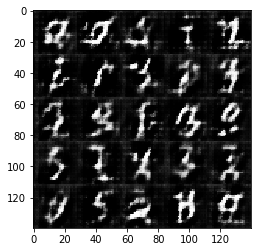

Epoch 1/2... Step 210 -> Discriminator Loss: 1.2576... Generator Loss: 0.8113
Epoch 1/2... Step 220 -> Discriminator Loss: 1.0347... Generator Loss: 0.8596
Epoch 1/2... Step 230 -> Discriminator Loss: 1.1741... Generator Loss: 1.0366
Epoch 1/2... Step 240 -> Discriminator Loss: 1.0326... Generator Loss: 0.8889
Epoch 1/2... Step 250 -> Discriminator Loss: 1.0395... Generator Loss: 1.1539
Epoch 1/2... Step 260 -> Discriminator Loss: 1.3408... Generator Loss: 0.5044
Epoch 1/2... Step 270 -> Discriminator Loss: 1.0896... Generator Loss: 0.9550
Epoch 1/2... Step 280 -> Discriminator Loss: 1.1905... Generator Loss: 0.6464
Epoch 1/2... Step 290 -> Discriminator Loss: 1.3400... Generator Loss: 0.5199
Epoch 1/2... Step 300 -> Discriminator Loss: 1.2106... Generator Loss: 0.5764


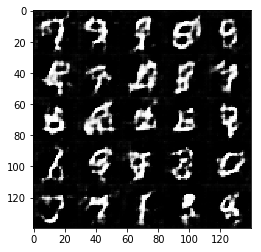

Epoch 1/2... Step 310 -> Discriminator Loss: 1.0100... Generator Loss: 1.1432
Epoch 1/2... Step 320 -> Discriminator Loss: 1.6426... Generator Loss: 0.2976
Epoch 1/2... Step 330 -> Discriminator Loss: 1.0128... Generator Loss: 1.0015
Epoch 1/2... Step 340 -> Discriminator Loss: 1.2558... Generator Loss: 1.1053
Epoch 1/2... Step 350 -> Discriminator Loss: 1.2933... Generator Loss: 0.7873
Epoch 1/2... Step 360 -> Discriminator Loss: 1.1408... Generator Loss: 0.7213
Epoch 1/2... Step 370 -> Discriminator Loss: 1.0894... Generator Loss: 0.7508
Epoch 1/2... Step 380 -> Discriminator Loss: 1.2628... Generator Loss: 1.2350
Epoch 1/2... Step 390 -> Discriminator Loss: 1.1111... Generator Loss: 1.2096
Epoch 1/2... Step 400 -> Discriminator Loss: 1.3399... Generator Loss: 0.4539


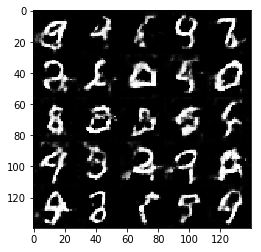

Epoch 1/2... Step 410 -> Discriminator Loss: 1.0618... Generator Loss: 0.9677
Epoch 1/2... Step 420 -> Discriminator Loss: 1.0861... Generator Loss: 0.9703
Epoch 1/2... Step 430 -> Discriminator Loss: 1.0788... Generator Loss: 0.9850
Epoch 1/2... Step 440 -> Discriminator Loss: 1.1069... Generator Loss: 0.8358
Epoch 1/2... Step 450 -> Discriminator Loss: 1.0368... Generator Loss: 0.8543
Epoch 1/2... Step 460 -> Discriminator Loss: 1.2526... Generator Loss: 0.6474
Epoch 2/2... Step 470 -> Discriminator Loss: 1.1195... Generator Loss: 1.0667
Epoch 2/2... Step 480 -> Discriminator Loss: 1.0833... Generator Loss: 1.0925
Epoch 2/2... Step 490 -> Discriminator Loss: 1.0317... Generator Loss: 1.0312
Epoch 2/2... Step 500 -> Discriminator Loss: 1.1920... Generator Loss: 0.7517


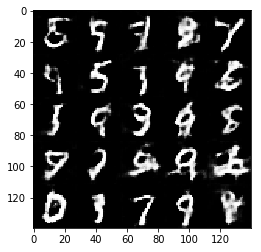

Epoch 2/2... Step 510 -> Discriminator Loss: 1.1793... Generator Loss: 0.7157
Epoch 2/2... Step 520 -> Discriminator Loss: 1.4155... Generator Loss: 0.4391
Epoch 2/2... Step 530 -> Discriminator Loss: 1.1127... Generator Loss: 0.8118
Epoch 2/2... Step 540 -> Discriminator Loss: 1.0738... Generator Loss: 0.9833
Epoch 2/2... Step 550 -> Discriminator Loss: 1.1634... Generator Loss: 1.2236
Epoch 2/2... Step 560 -> Discriminator Loss: 0.9922... Generator Loss: 0.8926
Epoch 2/2... Step 570 -> Discriminator Loss: 1.1835... Generator Loss: 1.4835
Epoch 2/2... Step 580 -> Discriminator Loss: 1.1450... Generator Loss: 0.8359
Epoch 2/2... Step 590 -> Discriminator Loss: 1.0647... Generator Loss: 0.9896
Epoch 2/2... Step 600 -> Discriminator Loss: 1.2248... Generator Loss: 1.2526


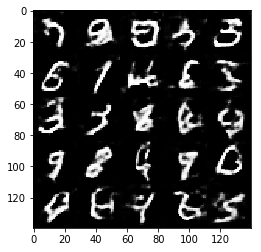

Epoch 2/2... Step 610 -> Discriminator Loss: 1.1457... Generator Loss: 0.8537
Epoch 2/2... Step 620 -> Discriminator Loss: 1.0062... Generator Loss: 1.0818
Epoch 2/2... Step 630 -> Discriminator Loss: 1.1271... Generator Loss: 0.8219
Epoch 2/2... Step 640 -> Discriminator Loss: 1.0944... Generator Loss: 0.9076
Epoch 2/2... Step 650 -> Discriminator Loss: 1.0470... Generator Loss: 0.9635
Epoch 2/2... Step 660 -> Discriminator Loss: 1.1267... Generator Loss: 0.7431
Epoch 2/2... Step 670 -> Discriminator Loss: 1.0346... Generator Loss: 1.1124
Epoch 2/2... Step 680 -> Discriminator Loss: 1.1256... Generator Loss: 0.9211
Epoch 2/2... Step 690 -> Discriminator Loss: 1.0440... Generator Loss: 1.1240
Epoch 2/2... Step 700 -> Discriminator Loss: 0.9592... Generator Loss: 1.0852


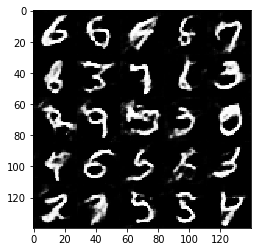

Epoch 2/2... Step 710 -> Discriminator Loss: 1.1767... Generator Loss: 0.6674
Epoch 2/2... Step 720 -> Discriminator Loss: 1.1449... Generator Loss: 0.7485
Epoch 2/2... Step 730 -> Discriminator Loss: 1.0293... Generator Loss: 0.8649
Epoch 2/2... Step 740 -> Discriminator Loss: 1.0368... Generator Loss: 0.8168
Epoch 2/2... Step 750 -> Discriminator Loss: 1.0613... Generator Loss: 1.0000
Epoch 2/2... Step 760 -> Discriminator Loss: 1.0755... Generator Loss: 0.8927
Epoch 2/2... Step 770 -> Discriminator Loss: 1.0493... Generator Loss: 0.7939
Epoch 2/2... Step 780 -> Discriminator Loss: 1.0982... Generator Loss: 0.7570
Epoch 2/2... Step 790 -> Discriminator Loss: 1.0670... Generator Loss: 0.9367
Epoch 2/2... Step 800 -> Discriminator Loss: 1.0386... Generator Loss: 1.0517


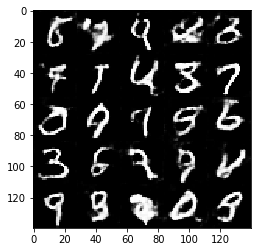

Epoch 2/2... Step 810 -> Discriminator Loss: 0.9543... Generator Loss: 1.2528
Epoch 2/2... Step 820 -> Discriminator Loss: 1.0153... Generator Loss: 1.1085
Epoch 2/2... Step 830 -> Discriminator Loss: 1.0720... Generator Loss: 0.7321
Epoch 2/2... Step 840 -> Discriminator Loss: 0.8677... Generator Loss: 1.2031
Epoch 2/2... Step 850 -> Discriminator Loss: 0.8683... Generator Loss: 1.2172
Epoch 2/2... Step 860 -> Discriminator Loss: 1.2292... Generator Loss: 0.7819
Epoch 2/2... Step 870 -> Discriminator Loss: 0.9563... Generator Loss: 1.0849
Epoch 2/2... Step 880 -> Discriminator Loss: 1.1241... Generator Loss: 1.1437
Epoch 2/2... Step 890 -> Discriminator Loss: 0.9837... Generator Loss: 1.0928
Epoch 2/2... Step 900 -> Discriminator Loss: 1.1250... Generator Loss: 0.9491


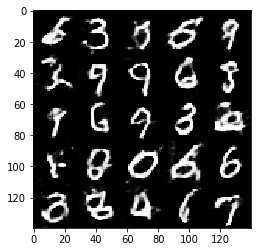

Epoch 2/2... Step 910 -> Discriminator Loss: 0.9896... Generator Loss: 1.0834
Epoch 2/2... Step 920 -> Discriminator Loss: 1.1178... Generator Loss: 0.8118
Epoch 2/2... Step 930 -> Discriminator Loss: 0.8942... Generator Loss: 0.9621


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10 -> Discriminator Loss: 1.7468... Generator Loss: 8.6692
Epoch 1/1... Step 20 -> Discriminator Loss: 2.0577... Generator Loss: 0.1799
Epoch 1/1... Step 30 -> Discriminator Loss: 0.7100... Generator Loss: 1.1079
Epoch 1/1... Step 40 -> Discriminator Loss: 1.1123... Generator Loss: 0.9117
Epoch 1/1... Step 50 -> Discriminator Loss: 1.0354... Generator Loss: 0.8282
Epoch 1/1... Step 60 -> Discriminator Loss: 1.1361... Generator Loss: 1.2088
Epoch 1/1... Step 70 -> Discriminator Loss: 1.2487... Generator Loss: 1.3508
Epoch 1/1... Step 80 -> Discriminator Loss: 1.8205... Generator Loss: 1.2479
Epoch 1/1... Step 90 -> Discriminator Loss: 1.2004... Generator Loss: 0.8597
Epoch 1/1... Step 100 -> Discriminator Loss: 1.2255... Generator Loss: 0.8435


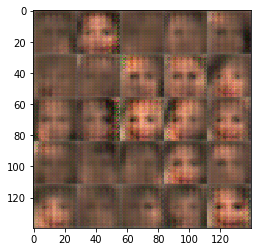

Epoch 1/1... Step 110 -> Discriminator Loss: 1.3806... Generator Loss: 0.5560
Epoch 1/1... Step 120 -> Discriminator Loss: 1.1876... Generator Loss: 0.7850
Epoch 1/1... Step 130 -> Discriminator Loss: 1.3079... Generator Loss: 0.7064
Epoch 1/1... Step 140 -> Discriminator Loss: 1.2970... Generator Loss: 0.9700
Epoch 1/1... Step 150 -> Discriminator Loss: 1.2488... Generator Loss: 0.6994
Epoch 1/1... Step 160 -> Discriminator Loss: 1.3852... Generator Loss: 0.6950
Epoch 1/1... Step 170 -> Discriminator Loss: 1.1886... Generator Loss: 0.7055
Epoch 1/1... Step 180 -> Discriminator Loss: 1.0182... Generator Loss: 0.9346
Epoch 1/1... Step 190 -> Discriminator Loss: 0.4615... Generator Loss: 1.6167
Epoch 1/1... Step 200 -> Discriminator Loss: 1.0350... Generator Loss: 0.9408


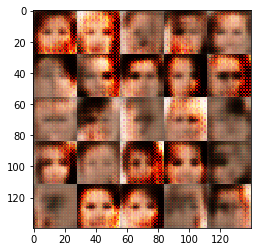

Epoch 1/1... Step 210 -> Discriminator Loss: 1.3314... Generator Loss: 1.0338
Epoch 1/1... Step 220 -> Discriminator Loss: 1.1989... Generator Loss: 0.7173
Epoch 1/1... Step 230 -> Discriminator Loss: 1.3809... Generator Loss: 0.6669
Epoch 1/1... Step 240 -> Discriminator Loss: 1.0602... Generator Loss: 0.7944
Epoch 1/1... Step 250 -> Discriminator Loss: 1.2201... Generator Loss: 0.7704
Epoch 1/1... Step 260 -> Discriminator Loss: 1.1697... Generator Loss: 0.7100
Epoch 1/1... Step 270 -> Discriminator Loss: 1.0507... Generator Loss: 1.3849
Epoch 1/1... Step 280 -> Discriminator Loss: 1.3624... Generator Loss: 1.2273
Epoch 1/1... Step 290 -> Discriminator Loss: 1.2268... Generator Loss: 0.7242
Epoch 1/1... Step 300 -> Discriminator Loss: 1.1472... Generator Loss: 0.8885


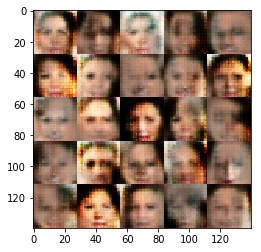

Epoch 1/1... Step 310 -> Discriminator Loss: 1.2853... Generator Loss: 0.8124
Epoch 1/1... Step 320 -> Discriminator Loss: 1.3305... Generator Loss: 0.7378
Epoch 1/1... Step 330 -> Discriminator Loss: 1.4500... Generator Loss: 0.9886
Epoch 1/1... Step 340 -> Discriminator Loss: 1.9593... Generator Loss: 0.2212
Epoch 1/1... Step 350 -> Discriminator Loss: 1.2399... Generator Loss: 0.7924
Epoch 1/1... Step 360 -> Discriminator Loss: 1.2873... Generator Loss: 0.7727
Epoch 1/1... Step 370 -> Discriminator Loss: 1.1380... Generator Loss: 0.8150
Epoch 1/1... Step 380 -> Discriminator Loss: 0.7887... Generator Loss: 1.3229
Epoch 1/1... Step 390 -> Discriminator Loss: 1.9767... Generator Loss: 1.9016
Epoch 1/1... Step 400 -> Discriminator Loss: 1.3884... Generator Loss: 0.6714


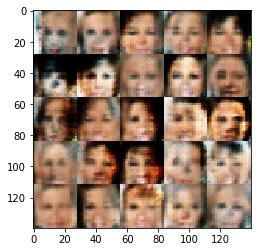

Epoch 1/1... Step 410 -> Discriminator Loss: 1.8969... Generator Loss: 0.2055
Epoch 1/1... Step 420 -> Discriminator Loss: 0.9141... Generator Loss: 1.1051
Epoch 1/1... Step 430 -> Discriminator Loss: 0.6844... Generator Loss: 1.5414
Epoch 1/1... Step 440 -> Discriminator Loss: 1.0596... Generator Loss: 0.9598
Epoch 1/1... Step 450 -> Discriminator Loss: 1.5581... Generator Loss: 1.5507
Epoch 1/1... Step 460 -> Discriminator Loss: 1.1426... Generator Loss: 0.8364
Epoch 1/1... Step 470 -> Discriminator Loss: 1.2743... Generator Loss: 0.6703
Epoch 1/1... Step 480 -> Discriminator Loss: 0.4658... Generator Loss: 1.3217
Epoch 1/1... Step 490 -> Discriminator Loss: 1.2682... Generator Loss: 0.6814
Epoch 1/1... Step 500 -> Discriminator Loss: 1.2850... Generator Loss: 0.8222


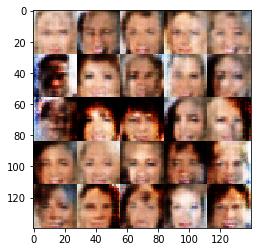

Epoch 1/1... Step 510 -> Discriminator Loss: 0.9300... Generator Loss: 1.1322
Epoch 1/1... Step 520 -> Discriminator Loss: 0.7545... Generator Loss: 1.0295
Epoch 1/1... Step 530 -> Discriminator Loss: 0.9457... Generator Loss: 0.8028
Epoch 1/1... Step 540 -> Discriminator Loss: 1.1278... Generator Loss: 0.5685
Epoch 1/1... Step 550 -> Discriminator Loss: 1.4363... Generator Loss: 0.6528
Epoch 1/1... Step 560 -> Discriminator Loss: 1.2448... Generator Loss: 0.8299
Epoch 1/1... Step 570 -> Discriminator Loss: 1.3839... Generator Loss: 0.6867
Epoch 1/1... Step 580 -> Discriminator Loss: 1.0758... Generator Loss: 0.9470
Epoch 1/1... Step 590 -> Discriminator Loss: 1.3485... Generator Loss: 0.7436
Epoch 1/1... Step 600 -> Discriminator Loss: 1.3144... Generator Loss: 0.7327


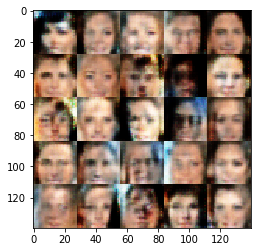

Epoch 1/1... Step 610 -> Discriminator Loss: 1.2348... Generator Loss: 1.1234
Epoch 1/1... Step 620 -> Discriminator Loss: 1.2818... Generator Loss: 1.0498
Epoch 1/1... Step 630 -> Discriminator Loss: 1.2308... Generator Loss: 0.7807
Epoch 1/1... Step 640 -> Discriminator Loss: 1.3874... Generator Loss: 0.6747
Epoch 1/1... Step 650 -> Discriminator Loss: 1.2445... Generator Loss: 0.8424
Epoch 1/1... Step 660 -> Discriminator Loss: 0.3925... Generator Loss: 1.7767
Epoch 1/1... Step 670 -> Discriminator Loss: 1.5639... Generator Loss: 1.3585
Epoch 1/1... Step 680 -> Discriminator Loss: 1.3390... Generator Loss: 0.7799
Epoch 1/1... Step 690 -> Discriminator Loss: 1.2254... Generator Loss: 0.8808
Epoch 1/1... Step 700 -> Discriminator Loss: 1.3123... Generator Loss: 0.7544


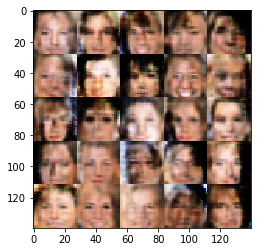

Epoch 1/1... Step 710 -> Discriminator Loss: 1.3204... Generator Loss: 0.7585
Epoch 1/1... Step 720 -> Discriminator Loss: 1.4074... Generator Loss: 1.3648
Epoch 1/1... Step 730 -> Discriminator Loss: 0.3716... Generator Loss: 2.2477
Epoch 1/1... Step 740 -> Discriminator Loss: 1.1146... Generator Loss: 0.8289
Epoch 1/1... Step 750 -> Discriminator Loss: 1.2996... Generator Loss: 0.9279
Epoch 1/1... Step 760 -> Discriminator Loss: 1.0676... Generator Loss: 0.6575
Epoch 1/1... Step 770 -> Discriminator Loss: 1.1855... Generator Loss: 0.9301
Epoch 1/1... Step 780 -> Discriminator Loss: 1.2810... Generator Loss: 0.7805
Epoch 1/1... Step 790 -> Discriminator Loss: 1.1782... Generator Loss: 0.6429
Epoch 1/1... Step 800 -> Discriminator Loss: 1.2023... Generator Loss: 0.7301


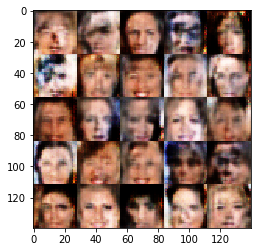

Epoch 1/1... Step 810 -> Discriminator Loss: 1.3815... Generator Loss: 0.8513
Epoch 1/1... Step 820 -> Discriminator Loss: 1.3052... Generator Loss: 0.7732
Epoch 1/1... Step 830 -> Discriminator Loss: 1.2566... Generator Loss: 0.6529
Epoch 1/1... Step 840 -> Discriminator Loss: 1.2554... Generator Loss: 0.5609
Epoch 1/1... Step 850 -> Discriminator Loss: 1.1101... Generator Loss: 0.6433
Epoch 1/1... Step 860 -> Discriminator Loss: 1.3035... Generator Loss: 0.7991
Epoch 1/1... Step 870 -> Discriminator Loss: 1.2283... Generator Loss: 0.6163
Epoch 1/1... Step 880 -> Discriminator Loss: 1.4841... Generator Loss: 0.4164
Epoch 1/1... Step 890 -> Discriminator Loss: 1.2104... Generator Loss: 0.7491
Epoch 1/1... Step 900 -> Discriminator Loss: 1.2406... Generator Loss: 0.4584


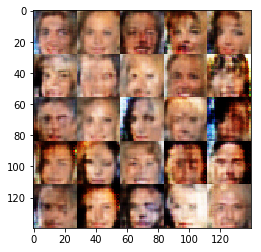

Epoch 1/1... Step 910 -> Discriminator Loss: 1.4194... Generator Loss: 0.6859
Epoch 1/1... Step 920 -> Discriminator Loss: 1.1730... Generator Loss: 0.8084
Epoch 1/1... Step 930 -> Discriminator Loss: 0.9107... Generator Loss: 1.1211
Epoch 1/1... Step 940 -> Discriminator Loss: 1.2662... Generator Loss: 0.6350
Epoch 1/1... Step 950 -> Discriminator Loss: 1.2179... Generator Loss: 0.6691
Epoch 1/1... Step 960 -> Discriminator Loss: 1.1808... Generator Loss: 0.7231
Epoch 1/1... Step 970 -> Discriminator Loss: 1.0966... Generator Loss: 0.9271
Epoch 1/1... Step 980 -> Discriminator Loss: 1.4778... Generator Loss: 0.6860
Epoch 1/1... Step 990 -> Discriminator Loss: 1.4445... Generator Loss: 0.4336
Epoch 1/1... Step 1000 -> Discriminator Loss: 1.1495... Generator Loss: 0.6457


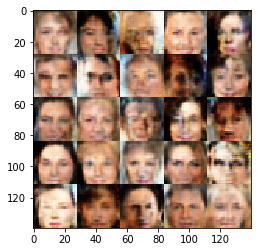

Epoch 1/1... Step 1010 -> Discriminator Loss: 0.9618... Generator Loss: 0.8379
Epoch 1/1... Step 1020 -> Discriminator Loss: 1.5229... Generator Loss: 1.4553
Epoch 1/1... Step 1030 -> Discriminator Loss: 1.5385... Generator Loss: 0.3450
Epoch 1/1... Step 1040 -> Discriminator Loss: 1.5959... Generator Loss: 0.6420
Epoch 1/1... Step 1050 -> Discriminator Loss: 1.4011... Generator Loss: 0.5432
Epoch 1/1... Step 1060 -> Discriminator Loss: 1.3042... Generator Loss: 0.7574
Epoch 1/1... Step 1070 -> Discriminator Loss: 1.3980... Generator Loss: 1.0843
Epoch 1/1... Step 1080 -> Discriminator Loss: 1.2346... Generator Loss: 0.6594
Epoch 1/1... Step 1090 -> Discriminator Loss: 0.9763... Generator Loss: 1.2741
Epoch 1/1... Step 1100 -> Discriminator Loss: 1.1441... Generator Loss: 0.7743


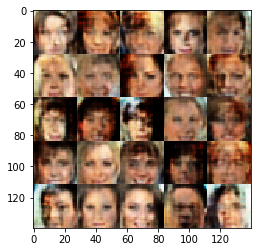

Epoch 1/1... Step 1110 -> Discriminator Loss: 1.4156... Generator Loss: 0.6800
Epoch 1/1... Step 1120 -> Discriminator Loss: 0.4037... Generator Loss: 1.7555
Epoch 1/1... Step 1130 -> Discriminator Loss: 1.3930... Generator Loss: 0.7249
Epoch 1/1... Step 1140 -> Discriminator Loss: 1.2963... Generator Loss: 0.6942
Epoch 1/1... Step 1150 -> Discriminator Loss: 1.2443... Generator Loss: 0.7102
Epoch 1/1... Step 1160 -> Discriminator Loss: 1.0550... Generator Loss: 0.9099
Epoch 1/1... Step 1170 -> Discriminator Loss: 1.2447... Generator Loss: 0.7270
Epoch 1/1... Step 1180 -> Discriminator Loss: 1.2714... Generator Loss: 0.8047
Epoch 1/1... Step 1190 -> Discriminator Loss: 1.1811... Generator Loss: 0.9400
Epoch 1/1... Step 1200 -> Discriminator Loss: 1.1057... Generator Loss: 0.9958


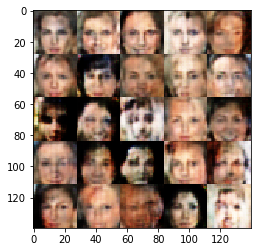

Epoch 1/1... Step 1210 -> Discriminator Loss: 1.2180... Generator Loss: 0.6274
Epoch 1/1... Step 1220 -> Discriminator Loss: 1.2098... Generator Loss: 0.7204
Epoch 1/1... Step 1230 -> Discriminator Loss: 1.4837... Generator Loss: 0.7748
Epoch 1/1... Step 1240 -> Discriminator Loss: 1.3586... Generator Loss: 0.8167
Epoch 1/1... Step 1250 -> Discriminator Loss: 1.3400... Generator Loss: 0.6927
Epoch 1/1... Step 1260 -> Discriminator Loss: 1.0388... Generator Loss: 0.9752
Epoch 1/1... Step 1270 -> Discriminator Loss: 1.0316... Generator Loss: 0.6498
Epoch 1/1... Step 1280 -> Discriminator Loss: 1.1784... Generator Loss: 0.7986
Epoch 1/1... Step 1290 -> Discriminator Loss: 1.3378... Generator Loss: 0.8292
Epoch 1/1... Step 1300 -> Discriminator Loss: 1.1052... Generator Loss: 0.8519


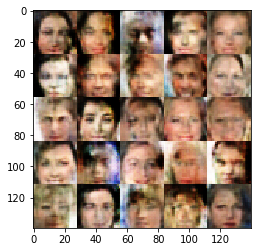

Epoch 1/1... Step 1310 -> Discriminator Loss: 1.1354... Generator Loss: 0.8047
Epoch 1/1... Step 1320 -> Discriminator Loss: 1.1863... Generator Loss: 0.8364
Epoch 1/1... Step 1330 -> Discriminator Loss: 1.5630... Generator Loss: 1.7846
Epoch 1/1... Step 1340 -> Discriminator Loss: 1.2296... Generator Loss: 0.8183
Epoch 1/1... Step 1350 -> Discriminator Loss: 1.3356... Generator Loss: 0.7514
Epoch 1/1... Step 1360 -> Discriminator Loss: 1.2230... Generator Loss: 1.0492
Epoch 1/1... Step 1370 -> Discriminator Loss: 1.1184... Generator Loss: 1.2873
Epoch 1/1... Step 1380 -> Discriminator Loss: 1.1463... Generator Loss: 0.7509
Epoch 1/1... Step 1390 -> Discriminator Loss: 1.1856... Generator Loss: 0.7158
Epoch 1/1... Step 1400 -> Discriminator Loss: 1.2258... Generator Loss: 0.6017


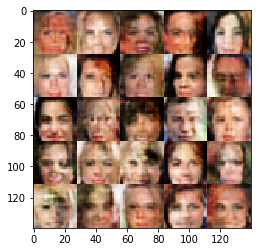

Epoch 1/1... Step 1410 -> Discriminator Loss: 1.1458... Generator Loss: 0.7570
Epoch 1/1... Step 1420 -> Discriminator Loss: 1.1687... Generator Loss: 0.8897
Epoch 1/1... Step 1430 -> Discriminator Loss: 1.4449... Generator Loss: 0.5939
Epoch 1/1... Step 1440 -> Discriminator Loss: 1.4209... Generator Loss: 0.5701
Epoch 1/1... Step 1450 -> Discriminator Loss: 0.9193... Generator Loss: 1.1812
Epoch 1/1... Step 1460 -> Discriminator Loss: 1.3413... Generator Loss: 0.6509
Epoch 1/1... Step 1470 -> Discriminator Loss: 1.2924... Generator Loss: 0.6994
Epoch 1/1... Step 1480 -> Discriminator Loss: 1.0909... Generator Loss: 0.7291
Epoch 1/1... Step 1490 -> Discriminator Loss: 0.8516... Generator Loss: 0.8745
Epoch 1/1... Step 1500 -> Discriminator Loss: 1.1747... Generator Loss: 0.9117


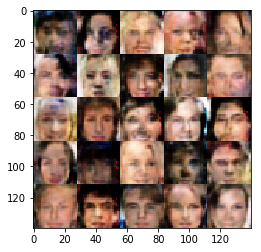

Epoch 1/1... Step 1510 -> Discriminator Loss: 1.3273... Generator Loss: 0.7275
Epoch 1/1... Step 1520 -> Discriminator Loss: 1.3005... Generator Loss: 0.7073
Epoch 1/1... Step 1530 -> Discriminator Loss: 1.3309... Generator Loss: 0.7050
Epoch 1/1... Step 1540 -> Discriminator Loss: 0.8595... Generator Loss: 1.7271
Epoch 1/1... Step 1550 -> Discriminator Loss: 1.5182... Generator Loss: 0.3877
Epoch 1/1... Step 1560 -> Discriminator Loss: 1.0539... Generator Loss: 0.6941
Epoch 1/1... Step 1570 -> Discriminator Loss: 1.1965... Generator Loss: 0.6289
Epoch 1/1... Step 1580 -> Discriminator Loss: 1.2698... Generator Loss: 0.8360


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.